# Sample crop and non-crop points from the KAZA landcover 2020 dataset

**Objective**

- Create a balanced dataset with 2 classes - crop and non-crop - based on the KAZA landcover 2020 dataset with each of the 2 classes containing n points.
- The non-crop class constitutes a selection of points from 17 non-crop landcover classes.

**Challenges**

- Idealy, the desired amount of points would be sampled from the crop and non-crop landcover classes for all given regions of interest at once - either randomly or enforcing a minimum amount of points per landcover class (e. g. 100) and then also considering their relative frequency (because some exist much more often than others).
- However, the dataset is too big to just sample points directly. So the 6 regions of interest have to be processed individually.
- But not all non-crop landcover classes exist in each region of interest in sufficient amounts (or at all).
- Thus, some rare non-crop landcover classes will be underrepresented if points are simply sampled randomly.

**Important and useful links**

- [KAZA Landcover 2020 Storymap](https://space-science.wwf.de/KAZAlandcover/)
- [KAZA Landcover 2020 Download](https://panda.maps.arcgis.com/home/item.html?id=0bd9f1902e4c4b9389d8c1f473c76d04) (there's also the link to the technical report)

**Steps**

- load and inspect KAZA Landcover 2020 raster and landcover mapping
- load and inspect 6 regions of interest shapefiles
- calculate relative areas and accordingly number of points to be sampled
- split large regions
- reproject crs
- process raster: for each roi
    - clip raster to roi geometry and mask array
    - extract data from masked array
    - transform to dataframe
    - sample n crop and non-crop points (n proportional to area)
    - transform to geodataframe
- combine sampled points from all 6 regions of interest
- validate sampled points
- train test split and validate split
- save sampled points as csv and geojson

## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import rasterio.mask
from rasterio import Affine
import geopandas as gpd
from shapely.geometry import Polygon
import json

In [2]:
%matplotlib inline

In [3]:
sns.set_style('whitegrid')

In [4]:
seed = 42

In [5]:
crop_landcover_code = 40

In [6]:
# specify number of points to be sampled for both classes combined
n = 2000

In [7]:
# select a sampling mode

# sampled non-crop points will represent the underlying unbalanced non-crop landcover class distribution
sampling_mode = 'random'

# number of points sampled from non-crop landcover classes will be equal for all non-crop landcover classes unless there are not enough or no points for a given non-crop landcover class
#sampling_mode = 'uniform'

## Load and inspect KAZA Landcover 2020 raster

In [8]:
raster_path = '../raw_data/kaza_landcover_2020'
raster_file = 'Land_Cover_KAZA_2021_TFCA.tif'
raster_file_path = os.path.join(raster_path, raster_file)
raster_file_path

'../raw_data/kaza_landcover_2020/Land_Cover_KAZA_2021_TFCA.tif'

In [9]:
kaza_landcover_2020 = rasterio.open(raster_file_path)

In [10]:
kaza_landcover_2020.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 117266,
 'height': 92929,
 'count': 1,
 'crs': CRS.from_epsg(32734),
 'transform': Affine(10.0, 0.0, 226890.268299328,
        0.0, -10.0, 8550840.20908763)}

In [11]:
kaza_landcover_2020.bounds

BoundingBox(left=226890.268299328, bottom=7621550.209087631, right=1399550.268299328, top=8550840.20908763)

In [12]:
landcover_mapping = pd.read_csv(os.path.join(raster_path, 'eoss4wwf_kaza_landcover_Aux/eoss4wwf_kaza_landcover_scheme.csv'), usecols=['code', 'class'])
landcover_mapping

,code,class
0,31,Open Herbaceous Vegetation
1,32,Open Herbaceous/Floodplain
2,40,Cropland
3,50,Built-up
4,60,Bare Area
5,61,Bare Floodplain Area
6,80,Water Bodies Permanent
7,81,Water Bodies Seasonal
8,90,Closed Herbaceous Wetland
9,91,Sparse Herbaceous Wetland


## Load and inspect 6 regions of interest shapefiles

In [13]:
roi_path = '../raw_data/aois_bengo'

In [14]:
binga = gpd.read_file(os.path.join(roi_path, 'Binga.shp'))[['geometry', 'area_km2']].assign(region='Binga')
hwange = gpd.read_file(os.path.join(roi_path, 'Hwange.shp'))[['geometry', 'area_km2']].assign(region='Hwange')
mufunta = gpd.read_file(os.path.join(roi_path, 'Mufunta.shp'))[['geometry', 'area_km2']].assign(region='Mufunta')
mulobesi = gpd.read_file(os.path.join(roi_path, 'Mulobesi.shp'))[['geometry', 'area_km2']].assign(region='Mulobesi')
sichifulo = gpd.read_file(os.path.join(roi_path, 'Sichifulo.shp'))[['geometry', 'area_km2']].assign(region='Sichifulo')
zambezi = gpd.read_file(os.path.join(roi_path, 'Zambezi.shp'))[['geometry', 'area_km2']].assign(region='Zambezi').to_crs(epsg=4326) # this file has a different crs than the others

In [15]:
regions_of_interest = pd.concat([binga, hwange, mufunta, mulobesi, sichifulo, zambezi], axis=0).reset_index(drop=True)
regions_of_interest

,geometry,area_km2,region
0,"POLYGON ((28.03345 -17.00237, 28.03354 -17.002...",14794.00,Binga
1,"POLYGON ((25.28677 -17.80647, 25.28691 -17.806...",30607.30,Hwange
2,"POLYGON ((25.58421 -14.53576, 25.58513 -14.539...",6938.41,Mufunta
3,"POLYGON ((25.49953 -16.18899, 25.50866 -16.190...",3918.62,Mulobesi
4,"POLYGON ((25.63143 -16.64816, 25.63567 -16.648...",3893.37,Sichifulo
5,"POLYGON ((24.42817 -17.47902, 24.43599 -17.479...",18939.10,Zambezi


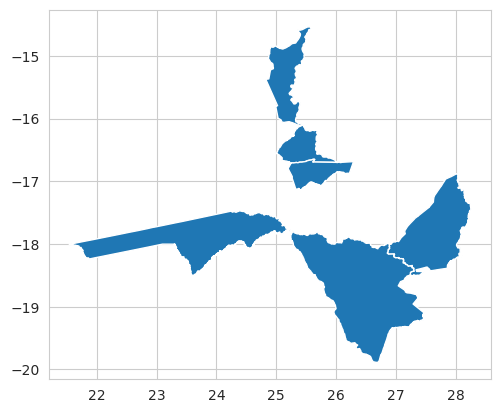

In [16]:
regions_of_interest.plot()
plt.show()

In [17]:
regions_of_interest.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
pd.concat([regions_of_interest['region'], regions_of_interest.bounds], axis=1)

,region,minx,miny,maxx,maxy
0,Binga,26.852225,-18.507756,28.251824,-16.876580
1,Hwange,25.237597,-19.888198,27.468296,-17.790122
2,Mufunta,24.824622,-16.108776,25.586628,-14.529700
3,Mulobesi,25.005018,-16.710792,26.005629,-16.093337
4,Sichifulo,25.196874,-17.137019,26.288657,-16.647680
5,Zambezi,21.541877,-18.501837,25.263637,-17.469283


### Calculate number of samples per region based on relative area

In [19]:
total_area = regions_of_interest['area_km2'].sum()
regions_of_interest['relative_area'] = regions_of_interest['area_km2'] / total_area
regions_of_interest['samples'] = (round((regions_of_interest['relative_area'] * (n / 2))) * 2).astype(np.uint32)
regions_of_interest

,geometry,area_km2,region,relative_area,samples
0,"POLYGON ((28.03345 -17.00237, 28.03354 -17.002...",14794.00,Binga,0.187051,374
1,"POLYGON ((25.28677 -17.80647, 25.28691 -17.806...",30607.30,Hwange,0.386989,774
2,"POLYGON ((25.58421 -14.53576, 25.58513 -14.539...",6938.41,Mufunta,0.087727,176
3,"POLYGON ((25.49953 -16.18899, 25.50866 -16.190...",3918.62,Mulobesi,0.049546,100
4,"POLYGON ((25.63143 -16.64816, 25.63567 -16.648...",3893.37,Sichifulo,0.049227,98
5,"POLYGON ((24.42817 -17.47902, 24.43599 -17.479...",18939.10,Zambezi,0.239460,478


### Split large regions

In [20]:
def split_large_regions(polygon, region_geodataframe, region_name, total_area, n, landcover_mapping):
    
    polygon_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=region_geodataframe.crs)
    
    west = region_geodataframe[region_geodataframe['region'] == region_name].clip(polygon_gdf)
    east = region_geodataframe[region_geodataframe['region'] == region_name].difference(west)
    
    region_area_original = region_geodataframe[region_geodataframe['region'] == region_name]['area_km2'][1]    
    region_area_calculated = (region_geodataframe[region_geodataframe['region'] == region_name].to_crs({'proj':'cea'}).area / 10**6)[1]
    west_area = (west.to_crs({'proj':'cea'}).area / 10**6)[1]
    east_area = (east.to_crs({'proj':'cea'}).area / 10**6)[1]
    
    data = {'region': [region_name + '_West', region_name + '_East'],
            'area_km2': [(west_area / region_area_calculated) * region_area_original, (east_area / region_area_calculated) * region_area_original],
            'relative_area': [np.nan, np.nan],
            'samples': [np.nan, np.nan],
            'geometry': [west['geometry'][1], east[1]]}
    
    west_east = gpd.GeoDataFrame(data)
    
    west_east['relative_area'] = west_east['area_km2'] / total_area
    west_east['samples'] = (round((west_east['relative_area'] * (n / 2))) * 2).astype(np.uint32)
    west_east['area_km2'] = round(west_east['area_km2'], 2)
    
    return west_east

In [21]:
hwange_split_polygon = Polygon([(25, -20), (25, -17.5), (26.5, -17.5), (26.5, -20), (25, -20)])
hwange_split = split_large_regions(hwange_split_polygon, regions_of_interest, 'Hwange', total_area, n, landcover_mapping)
hwange_split = hwange_split.set_crs(epsg=4326)
hwange_split

,region,area_km2,relative_area,samples,geometry
0,Hwange_West,16478.48,0.208349,416,"POLYGON ((25.28691 -17.80660, 25.28704 -17.806..."
1,Hwange_East,14128.82,0.178640,358,"POLYGON ((26.50004 -17.98351, 26.50019 -17.983..."


In [22]:
regions_of_interest = pd.concat([regions_of_interest, hwange_split], axis=0).reset_index(drop=True)
regions_of_interest

,geometry,area_km2,region,relative_area,samples
0,"POLYGON ((28.03345 -17.00237, 28.03354 -17.002...",14794.00,Binga,0.187051,374
1,"POLYGON ((25.28677 -17.80647, 25.28691 -17.806...",30607.30,Hwange,0.386989,774
2,"POLYGON ((25.58421 -14.53576, 25.58513 -14.539...",6938.41,Mufunta,0.087727,176
3,"POLYGON ((25.49953 -16.18899, 25.50866 -16.190...",3918.62,Mulobesi,0.049546,100
4,"POLYGON ((25.63143 -16.64816, 25.63567 -16.648...",3893.37,Sichifulo,0.049227,98
5,"POLYGON ((24.42817 -17.47902, 24.43599 -17.479...",18939.10,Zambezi,0.239460,478
6,"POLYGON ((25.28691 -17.80660, 25.28704 -17.806...",16478.48,Hwange_West,0.208349,416
7,"POLYGON ((26.50004 -17.98351, 26.50019 -17.983...",14128.82,Hwange_East,0.178640,358


In [23]:
regions_of_interest = regions_of_interest.to_crs(epsg=32734)

## Clip raster, extract data and sample points

[Inspiration](https://gis.stackexchange.com/questions/384954/cutting-a-polygon-from-tiff-with-python)

In [24]:
def clip_raster(raster_file_path, region_geodataframe, region_name):
    
    region_index = region_geodataframe[region_geodataframe['region'] == region_name].index[0]

    with rasterio.open(raster_file_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, [region_geodataframe.loc[region_index]['geometry']], crop=True)
        out_meta = src.meta

        out_meta.update(
            {
                'height': out_image.shape[1],
                'width': out_image.shape[2],
                'transform': out_transform,
            }
        )
        
        out_file_path = raster_file_path.replace(raster_file_path.split('/')[-1], '')
        out_file_name = region_name.lower() + '.tif'

        with rasterio.open(os.path.join(out_file_path, out_file_name), 'w', **out_meta) as dest:
            dest.write(out_image)
    
    return out_transform

[Inspiration](https://gis.stackexchange.com/questions/260304/extract-raster-values-within-shapefile-with-pygeoprocessing-or-gdal)

In [25]:
def extract_data_from_raster(raster_file_path):
    
    raster = rasterio.open(raster_file_path)    
    masked_array = raster.read(1, masked=True)
    
    no_data = raster.nodata    
    data = masked_array.data
    
    row, col = np.where(data != no_data)
    landcover_class = np.extract(data != no_data, data)
    
    dataframe = pd.DataFrame({'col': col, 'row': row, 'landcover_class': landcover_class})
    
    return dataframe

In [26]:
def sample_points(points_dataframe, regions_dataframe, region_name, crop_landcover_code, landcover_mapping, n, sampling_mode='random'):
    
    n_points = round(regions_dataframe[regions_dataframe['region'] == region_name]['samples'].values[0] / 2)
    
    print(f'        Sampling {n_points} crop points...')
    crop_samples = points_dataframe[points_dataframe['landcover_class'] == crop_landcover_code].sample(n_points, random_state=seed)    
    
    print(f'        Sampling {n_points} non-crop points...')
    
    existing_landcover_codes = list(points_dataframe[~points_dataframe['landcover_class'].isin([crop_landcover_code])]['landcover_class'].unique())
    existing_landcover_codes.extend([crop_landcover_code])
    not_existing_landcover_codes = list(landcover_mapping[~landcover_mapping['code'].isin(existing_landcover_codes)]['class'])
    
    if sampling_mode == 'random':
        non_crop_samples = points_dataframe[points_dataframe['landcover_class'] != crop_landcover_code].sample(n_points, random_state=seed)
    
    elif sampling_mode == 'uniform':    
    
        if len(not_existing_landcover_codes) > 0:
            print(f'            The following landcover classes do not exist in {region}:')
            for landcover_class in not_existing_landcover_codes:
                print(f'                {landcover_class}')

        non_crop_samples = pd.DataFrame()
        n_points_per_non_crop_landcover_class = round(n_points / len(existing_landcover_codes))

        for code in existing_landcover_codes:

            samples = points_dataframe[points_dataframe['landcover_class'].isin([code])].reset_index(drop=True)
            total_samples = len(samples)

            if total_samples >= n_points_per_non_crop_landcover_class:
                non_crop_samples = pd.concat([non_crop_samples, samples.sample(n_points_per_non_crop_landcover_class, random_state=seed)], ignore_index=True)
            elif total_samples > 0 & total_samples < n_points_per_non_crop_landcover_class:
                print(f'            Not enough samples for landcover class {code}; using only {total_samples} samples instead...')
                non_crop_samples = pd.concat([non_crop_samples, samples.sample(total_samples, random_state=seed)], ignore_index=True)
    
    else:
        print('Please select a valid sampling mode.')
        
    all_samples = pd.concat([crop_samples, non_crop_samples]).reset_index(drop=True)
    all_samples['region'] = region_name
    
    return all_samples

In [27]:
def make_geodataframe(dataframe, out_transform):
    
    T1 = out_transform * Affine.translation(0.5, 0.5)
    rc2xy = lambda r, c: (c, r) * T1
    
    dataframe['x'] = dataframe.apply(lambda row: rc2xy(row.row, row.col)[0], axis=1)
    dataframe['y'] = dataframe.apply(lambda row: rc2xy(row.row, row.col)[1], axis=1)
    
    geodataframe = gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy(dataframe.x, dataframe.y))
    
    return geodataframe

In [28]:
regions = regions_of_interest[regions_of_interest['region'] != 'Hwange']['region'].unique()
regions

array(['Binga', 'Mufunta', 'Mulobesi', 'Sichifulo', 'Zambezi',
       'Hwange_West', 'Hwange_East'], dtype=object)

In [29]:
%%time

landcover_class_distribution_per_region = pd.DataFrame()
sampled_points_per_region = pd.DataFrame()

for region in regions:
    
    print(f'Processing {region}...')
    
    print('    Clipping raster...')
    out_transform = clip_raster(raster_file_path, regions_of_interest, region)
    
    print('    Extracting data...')
    df = extract_data_from_raster(os.path.join(raster_path, region.lower() + '.tif'))
    
    print('    Getting landcover class distribution...')
    landcover_class_distribution = df['landcover_class'].value_counts().to_frame('count').reset_index()
    landcover_class_distribution = landcover_class_distribution.rename(columns={'index': 'code'})
    landcover_class_distribution['region'] = region
    landcover_class_distribution_per_region = pd.concat([landcover_class_distribution_per_region, landcover_class_distribution], ignore_index=True)
    
    print('    Sampling points...')
    samples = sample_points(df, regions_of_interest, region, crop_landcover_code, landcover_mapping, n, sampling_mode=sampling_mode)
    
    print('    Making geodataframe...')
    samples_gdf = make_geodataframe(samples, out_transform)
    
    sampled_points_per_region = pd.concat([sampled_points_per_region, samples_gdf], ignore_index=True)
    
    print(f'Processing {region} completed.')
    print('\n')

Processing Binga...
    Clipping raster...
    Extracting data...
    Getting landcover class distribution...
    Sampling points...
        Sampling 187 crop points...
        Sampling 187 non-crop points...
    Making geodataframe...
Processing Binga completed.


Processing Mufunta...
    Clipping raster...


/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


    Extracting data...
    Getting landcover class distribution...
    Sampling points...
        Sampling 88 crop points...
        Sampling 88 non-crop points...
    Making geodataframe...
Processing Mufunta completed.


Processing Mulobesi...
    Clipping raster...


/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


    Extracting data...
    Getting landcover class distribution...
    Sampling points...
        Sampling 50 crop points...
        Sampling 50 non-crop points...
    Making geodataframe...
Processing Mulobesi completed.


Processing Sichifulo...
    Clipping raster...


/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


    Extracting data...
    Getting landcover class distribution...
    Sampling points...
        Sampling 49 crop points...
        Sampling 49 non-crop points...
    Making geodataframe...
Processing Sichifulo completed.


Processing Zambezi...
    Clipping raster...


/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


    Extracting data...
    Getting landcover class distribution...
    Sampling points...
        Sampling 239 crop points...
        Sampling 239 non-crop points...
    Making geodataframe...
Processing Zambezi completed.


Processing Hwange_West...
    Clipping raster...


/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


    Extracting data...
    Getting landcover class distribution...
    Sampling points...
        Sampling 208 crop points...
        Sampling 208 non-crop points...
    Making geodataframe...


/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


Processing Hwange_West completed.


Processing Hwange_East...
    Clipping raster...


/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


    Extracting data...
    Getting landcover class distribution...
    Sampling points...
        Sampling 179 crop points...
        Sampling 179 non-crop points...
    Making geodataframe...
Processing Hwange_East completed.


CPU times: user 2min 33s, sys: 28.4 s, total: 3min 1s
Wall time: 3min 1s


/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_4473/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


## Validate processed and sampled data

### Landcover class distribution

In [30]:
landcover_class_distribution_per_region['region'] = landcover_class_distribution_per_region['region'].apply(lambda x: x.replace('_West', '').replace('_East', ''))
landcover_class_distribution_per_region = landcover_class_distribution_per_region.groupby(['code', 'region']).sum().reset_index()
landcover_class_distribution_per_region

,code,region,count
0,31,Binga,2803792
1,31,Hwange,4511997
2,31,Mufunta,249805
3,31,Mulobesi,275251
4,31,Sichifulo,352956
...,...,...,...
76,232,Hwange,69283541
77,232,Mufunta,432168
78,232,Mulobesi,3983162
79,232,Sichifulo,2504910


In [31]:
landcover_class_distribution_per_region.region.value_counts()

Mufunta      16
Zambezi      16
Hwange       14
Sichifulo    13
Mulobesi     12
Binga        10
Name: region, dtype: int64

In [32]:
landcover_class_distribution_absolute = pd.merge(landcover_mapping, landcover_class_distribution_per_region, how='left', on='code')
landcover_class_distribution_absolute = pd.pivot_table(landcover_class_distribution_absolute, index=['code', 'class'], columns='region', values='count').reset_index()
landcover_class_distribution_absolute = landcover_class_distribution_absolute.rename_axis(None, axis=1)
landcover_class_distribution_absolute

,code,class,Binga,Hwange,Mufunta,Mulobesi,Sichifulo,Zambezi
0,31,Open Herbaceous Vegetation,2803792.0,4511997.0,249805.0,275251.0,352956.0,1231575.0
1,32,Open Herbaceous/Floodplain,NaN,NaN,4810089.0,336029.0,67.0,2239143.0
2,40,Cropland,35240797.0,9855713.0,3776265.0,366496.0,5208176.0,6515967.0
3,50,Built-up,37986.0,208126.0,2585.0,3.0,328.0,263930.0
4,61,Bare Floodplain Area,NaN,NaN,302879.0,NaN,NaN,239355.0
5,80,Water Bodies Permanent,10152257.0,491352.0,444.0,NaN,NaN,1307181.0
6,81,Water Bodies Seasonal,746525.0,222234.0,12508.0,NaN,1009.0,9584541.0
7,90,Closed Herbaceous Wetland,NaN,23321.0,NaN,NaN,NaN,443347.0
8,91,Sparse Herbaceous Wetland,NaN,13592.0,601259.0,79284.0,16985.0,7377167.0
9,92,Open Herbaceous Wetland,NaN,2613448.0,390909.0,30798.0,445458.0,6571396.0


The landcover class 'Bare Area' (Code 60) doesn't exist in any of the regions of interest.

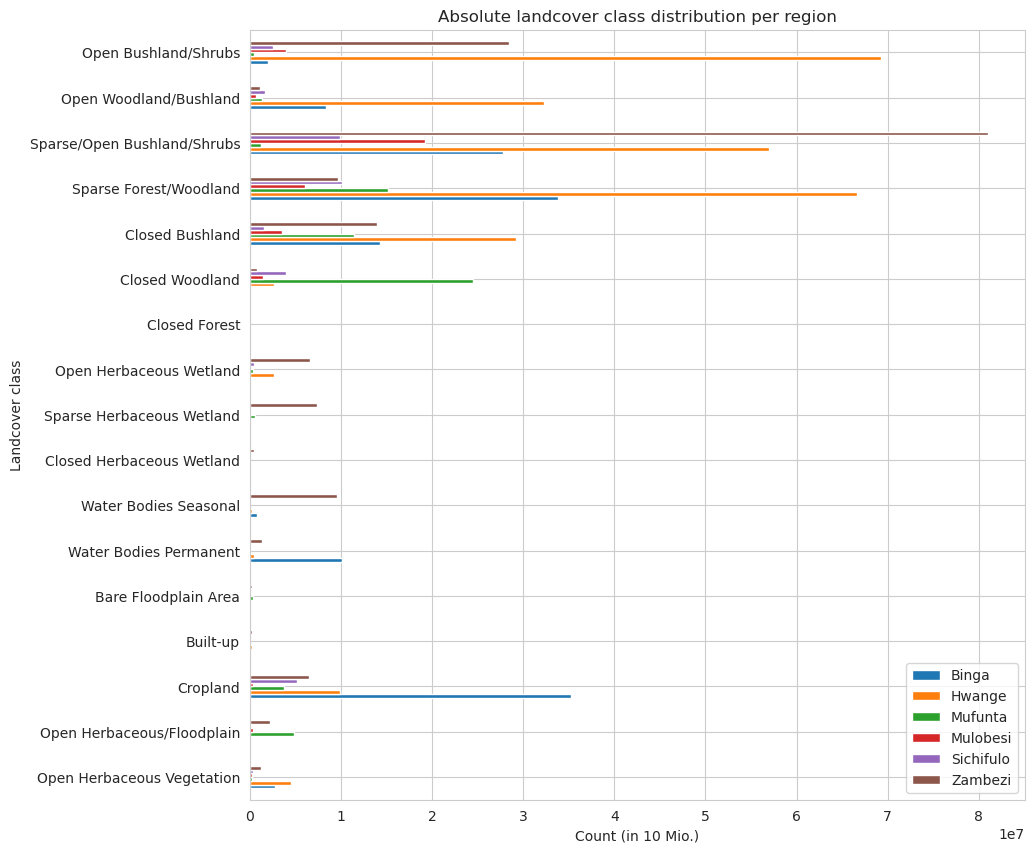

In [33]:
landcover_class_distribution_absolute.drop('code', axis=1).plot.barh(x='class', figsize=(10,10))
plt.title('Absolute landcover class distribution per region')
plt.xlabel('Count (in 10 Mio.)')
plt.ylabel('Landcover class')
plt.show()

In [34]:
landcover_class_distribution_relative = landcover_class_distribution_absolute.copy()
for region in landcover_class_distribution_per_region['region'].unique():
    landcover_class_distribution_relative[region] = (landcover_class_distribution_relative[region] / landcover_class_distribution_relative[region].sum()) * 100
landcover_class_distribution_relative

,code,class,Binga,Hwange,Mufunta,Mulobesi,Sichifulo,Zambezi
0,31,Open Herbaceous Vegetation,2.073930,1.640905,0.387926,0.764438,0.990046,0.721066
1,32,Open Herbaceous/Floodplain,NaN,NaN,7.469660,0.933233,0.000188,1.310979
2,40,Cropland,26.067173,3.584286,5.864219,1.017847,14.608994,3.814984
3,50,Built-up,0.028098,0.075690,0.004014,0.000008,0.000920,0.154526
4,61,Bare Floodplain Area,NaN,NaN,0.470345,NaN,NaN,0.140138
5,80,Water Bodies Permanent,7.509496,0.178693,0.000689,NaN,NaN,0.765332
6,81,Water Bodies Seasonal,0.552195,0.080821,0.019424,NaN,0.002830,5.611581
7,90,Closed Herbaceous Wetland,NaN,0.008481,NaN,NaN,NaN,0.259572
8,91,Sparse Herbaceous Wetland,NaN,0.004943,0.933704,0.220191,0.047643,4.319202
9,92,Open Herbaceous Wetland,NaN,0.950448,0.607048,0.085533,1.249515,3.847437


In [35]:
landcover_class_distribution_relative.drop(['code', 'class'], axis=1).sum()

Binga        100.0
Hwange       100.0
Mufunta      100.0
Mulobesi     100.0
Sichifulo    100.0
Zambezi      100.0
dtype: float64

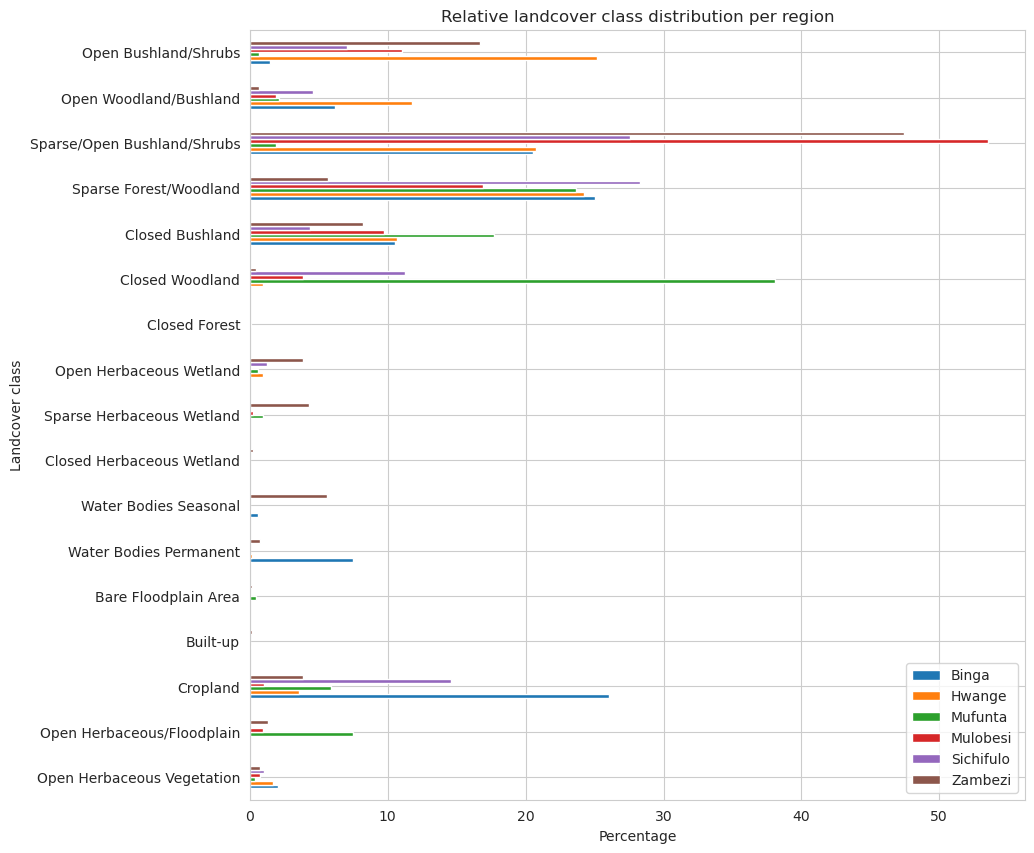

In [36]:
landcover_class_distribution_relative.drop('code', axis=1).plot.barh(x='class', figsize=(10,10))
plt.title('Relative landcover class distribution per region')
plt.xlabel('Percentage')
plt.ylabel('Landcover class')
plt.show()

Interestingly, the share of cropland in the 6 Bengo regions is about 9% whereas it is only about 4% for all of KAZA.

### Sampled points

In [37]:
sampled_points_per_region = sampled_points_per_region.drop(['col', 'row', 'x', 'y'], axis=1)
sampled_points_per_region = sampled_points_per_region.set_crs(epsg=32734)
sampled_points_per_region = sampled_points_per_region.to_crs(epsg=4326)
sampled_points_per_region

,landcover_class,region,geometry
0,40,Binga,POINT (27.51612 -18.04621)
1,40,Binga,POINT (27.29007 -18.12874)
2,40,Binga,POINT (27.59496 -18.31017)
3,40,Binga,POINT (27.14252 -17.91986)
4,40,Binga,POINT (27.25322 -18.12967)
...,...,...,...
1995,130,Hwange_East,POINT (26.89006 -19.01622)
1996,210,Hwange_East,POINT (26.83723 -19.00468)
1997,210,Hwange_East,POINT (26.54039 -19.04913)
1998,232,Hwange_East,POINT (26.75330 -18.03721)


In [38]:
sampled_points_per_region = pd.merge(sampled_points_per_region, landcover_mapping, how='inner', left_on='landcover_class', right_on='code')
sampled_points_per_region = sampled_points_per_region.drop('code', axis=1)
sampled_points_per_region

,landcover_class,region,geometry,class
0,40,Binga,POINT (27.51612 -18.04621),Cropland
1,40,Binga,POINT (27.29007 -18.12874),Cropland
2,40,Binga,POINT (27.59496 -18.31017),Cropland
3,40,Binga,POINT (27.14252 -17.91986),Cropland
4,40,Binga,POINT (27.25322 -18.12967),Cropland
...,...,...,...,...
1995,91,Zambezi,POINT (23.56945 -18.28920),Sparse Herbaceous Wetland
1996,91,Zambezi,POINT (24.01158 -18.15355),Sparse Herbaceous Wetland
1997,91,Zambezi,POINT (24.95271 -17.63727),Sparse Herbaceous Wetland
1998,91,Zambezi,POINT (24.97588 -17.62119),Sparse Herbaceous Wetland


In [39]:
non_crop_landcover_frequencies = sampled_points_per_region[sampled_points_per_region['landcover_class'] != crop_landcover_code]['class'].value_counts().sort_values(ascending=True)
non_crop_landcover_frequencies

Sparse Herbaceous Wetland        9
Open Herbaceous/Floodplain      10
Water Bodies Seasonal           16
Open Herbaceous Vegetation      17
Open Herbaceous Wetland         18
Water Bodies Permanent          20
Closed Woodland                 50
Open Woodland/Bushland          73
Closed Bushland                111
Open Bushland/Shrubs           165
Sparse Forest/Woodland         227
Sparse/Open Bushland/Shrubs    284
Name: class, dtype: int64

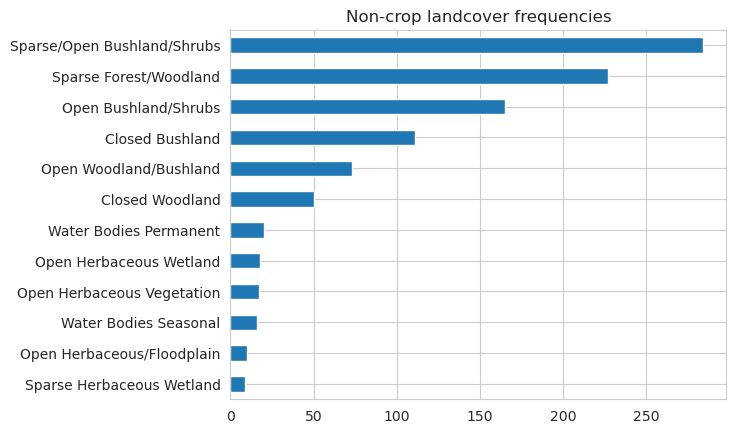

In [40]:
non_crop_landcover_frequencies.plot.barh(title='Non-crop landcover frequencies')
plt.show()

In [41]:
regions_of_interest_outline = regions_of_interest[~regions_of_interest['region'].isin(['Hwange_West', 'Hwange_East'])].exterior.to_crs(epsg=4326)

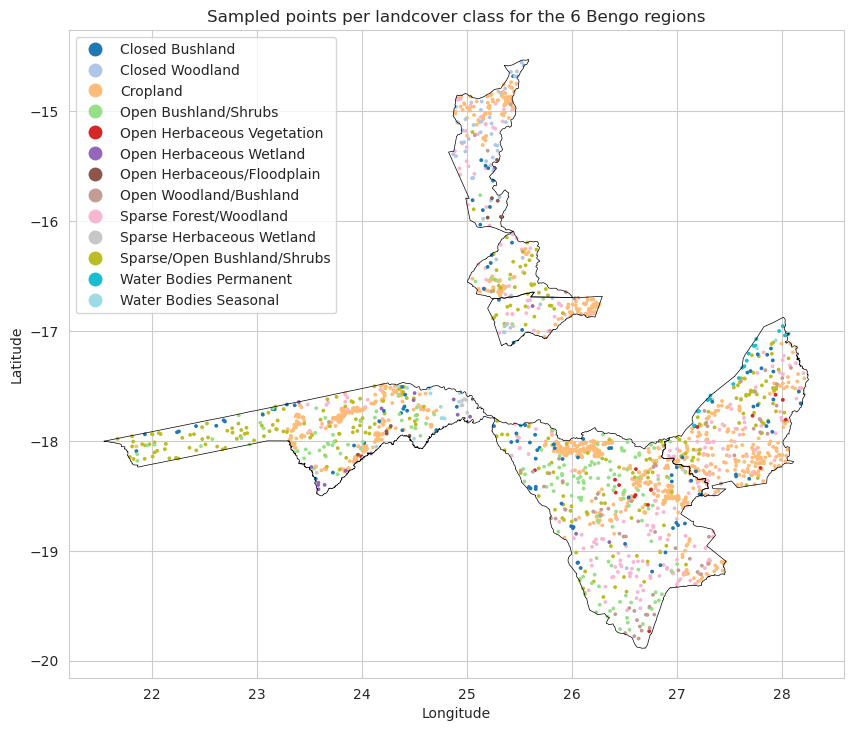

In [42]:
fig, ax = plt.subplots(figsize=(10,10))

regions_of_interest_outline.plot(ax=ax, edgecolor='black', linewidth=0.5)

sampled_points_per_region.plot(ax=ax, column='class', markersize=3, categorical=True, legend=True, label='class', cmap='tab20')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sampled points per landcover class for the 6 Bengo regions')

plt.show()

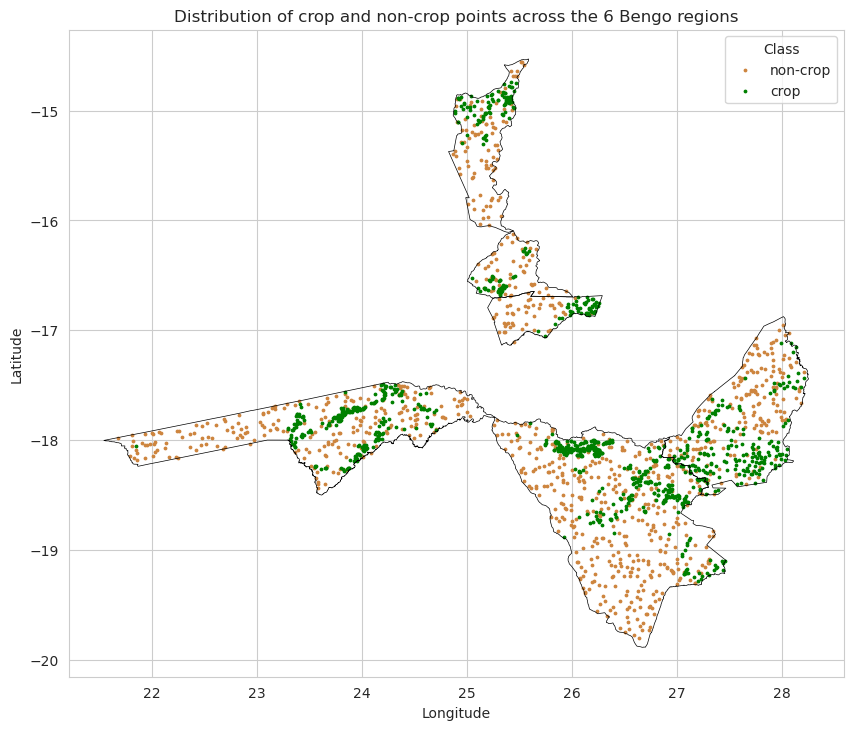

In [43]:
fig, ax = plt.subplots(figsize=(10,10))

regions_of_interest_outline.plot(ax=ax, edgecolor='black', linewidth=0.5)

sampled_points_per_region[sampled_points_per_region['landcover_class'] != crop_landcover_code].plot(ax=ax, markersize=3, color='peru', label='non-crop')
sampled_points_per_region[sampled_points_per_region['landcover_class'] == crop_landcover_code].plot(ax=ax, markersize=3, color='green', label='crop')

plt.legend(title='Class')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of crop and non-crop points across the 6 Bengo regions')

plt.show()

## Train test split

In [44]:
sampled_points_per_region = sampled_points_per_region.sample(frac=1, random_state=seed).reset_index(drop=True)
sampled_points_per_region['subset'] = ['train'] * round(len(sampled_points_per_region) * 0.8) + ['test'] * round(len(sampled_points_per_region) * 0.2)
sampled_points_per_region

,landcover_class,region,geometry,class,subset
0,231,Hwange_West,POINT (26.27313 -18.67769),Open Woodland/Bushland,train
1,40,Sichifulo,POINT (26.22911 -16.78453),Cropland,train
2,222,Zambezi,POINT (23.91473 -17.64923),Sparse/Open Bushland/Shrubs,train
3,40,Hwange_East,POINT (26.88519 -18.55946),Cropland,train
4,222,Mufunta,POINT (25.05245 -15.19111),Sparse/Open Bushland/Shrubs,train
...,...,...,...,...,...
1995,210,Hwange_West,POINT (26.22830 -18.89666),Sparse Forest/Woodland,test
1996,222,Mulobesi,POINT (25.44007 -16.37118),Sparse/Open Bushland/Shrubs,test
1997,40,Hwange_East,POINT (27.43635 -19.18086),Cropland,test
1998,222,Hwange_West,POINT (25.81123 -17.89990),Sparse/Open Bushland/Shrubs,test


In [45]:
sampled_points_per_region['subset'].value_counts()

train    1600
test      400
Name: subset, dtype: int64

In [46]:
sampled_points_per_region[sampled_points_per_region['landcover_class'] == crop_landcover_code]['subset'].value_counts()

train    818
test     182
Name: subset, dtype: int64

In [47]:
sampled_points_per_region[sampled_points_per_region['landcover_class'] != crop_landcover_code]['subset'].value_counts()

train    782
test     218
Name: subset, dtype: int64

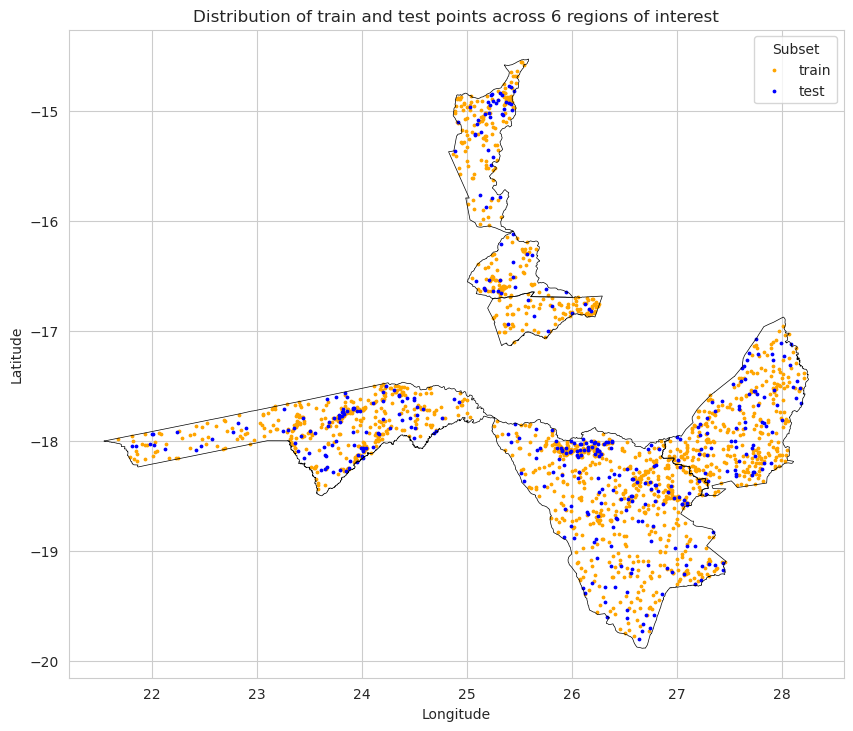

In [48]:
fig, ax = plt.subplots(figsize=(10,10))

regions_of_interest_outline.plot(ax=ax, edgecolor='black', linewidth=0.5)

sampled_points_per_region[sampled_points_per_region['subset'] == 'train'].plot(ax=ax, markersize=3, color='orange', label='train')
sampled_points_per_region[sampled_points_per_region['subset'] == 'test'].plot(ax=ax, markersize=3, color='blue', label='test')

plt.legend(title='Subset')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of train and test points across 6 regions of interest')

plt.show()

## Save labels

In [49]:
sampled_points_per_region['crop'] = sampled_points_per_region['landcover_class'].apply(lambda x: 1 if x == crop_landcover_code else 0)
sampled_points_per_region['lat'] = sampled_points_per_region['geometry'].y
sampled_points_per_region['lon'] = sampled_points_per_region['geometry'].x
labels = sampled_points_per_region[['lat', 'lon', 'crop', 'subset']].copy()
labels

,lat,lon,crop,subset
0,-18.677686,26.273130,0,train
1,-16.784527,26.229109,1,train
2,-17.649228,23.914734,0,train
3,-18.559455,26.885187,1,train
4,-15.191106,25.052454,0,train
...,...,...,...,...
1995,-18.896664,26.228298,0,test
1996,-16.371185,25.440068,0,test
1997,-19.180858,27.436347,1,test
1998,-17.899901,25.811227,0,test


In [50]:
labels_file_path = '../processed_data'
labels_file_name = 'kaza_bengo_crop_2020' + '_' + sampling_mode + '_' + str(n)

### CSV

In [51]:
labels.to_csv(os.path.join(labels_file_path, '{}.csv'.format(labels_file_name)), index=False)

### GeoJSON

[Inspiration](https://stackoverflow.com/questions/60382659/generate-geojson-using-pandas-datframe)

In [52]:
geojson = {'type': 'FeatureCollection', 'features': []}

for _, row in labels.iterrows():
    feature = {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [row['lon'], row['lat']]}, 'properties': {'crop': row['crop'], 'subset': row['subset']}}
    geojson['features'].append(feature)

with open(os.path.join(labels_file_path, '{}.geojson'.format(labels_file_name)), 'w') as fp:
    json.dump(geojson, fp)

In [53]:
# load geojson to make sure it was saved correctly
test_geojson = gpd.read_file(os.path.join(labels_file_path, '{}.geojson'.format(labels_file_name)))
test_geojson

,crop,subset,geometry
0,0,train,POINT (26.27313 -18.67769)
1,1,train,POINT (26.22911 -16.78453)
2,0,train,POINT (23.91473 -17.64923)
3,1,train,POINT (26.88519 -18.55946)
4,0,train,POINT (25.05245 -15.19111)
...,...,...,...
1995,0,test,POINT (26.22830 -18.89666)
1996,0,test,POINT (25.44007 -16.37118)
1997,1,test,POINT (27.43635 -19.18086)
1998,0,test,POINT (25.81123 -17.89990)
